In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import sys
sys.path.append('../')
import pandas as pd
import statsmodels.api as sm
from plotnine import ggplot, aes, geom_line, theme, labs
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.0)
from utils import set_freq, compute_accuracy

## 8.2 Methods with trend
### Holt's linear trend method

This method involves a forecast equation and two smoothing equations (one for the level and one for the trend):
$$
\begin{align*}
\text{Forecast equation} &\quad \hat{y}_{t+h|t} = \ell_t + hb_t\\
\text{Level equation} &\quad \ell_t = \alpha y_t + (1-\alpha)(\ell_{t-1} + b_{t-1}) \\
\text{Trend equation} &\quad b_t = \beta^*(\ell_t-\ell_{t-1}) + (1-\beta^*)b_{t-1},
\end{align*}
$$
where $\ell_t$ denotes an estimate of the level of the series at time $t$, $b_t$ denotes an estimate of the trend (slope) of the series at time $t$, $\alpha$ is the smoothing parameter for the level, $0\le\alpha\le 1$, and $\beta^*$ is the smoothing parameter for the trend, $0\le\beta^*\le 1$. 

The level equation here shows that $\ell_t$ is a weighted average of observation $y_t$ and the one-step-ahead forecast for time $t$, here given by $\ell_{t-1} + b_{t-1}$. The trend equation shows that $b_t$ is a weighted average of the estimated trend at time $t$ based on $\ell_t-\ell_{t-1}$ and $b_{t-1}$, the previous estimate of the trend.

The forecast function is no longer flat but trending. The $h$-step-ahead forecast is equal to the last estimated level plus $h$ times the last estimated trend value. Hence the forecasts are a linear function of $h$. 

#### Example: Australian Population

In [13]:
global_economy = (pd.read_csv('../data/tsibbledata/global_economy.csv', parse_dates=['Year'])
    .rename(columns={'Year': 'Date'})
    .assign(Pop=lambda df: df['Population']/1.e6)
    .set_index('Date')
)
aus_economy = global_economy.query('Code == "AUS"').pipe(set_freq)

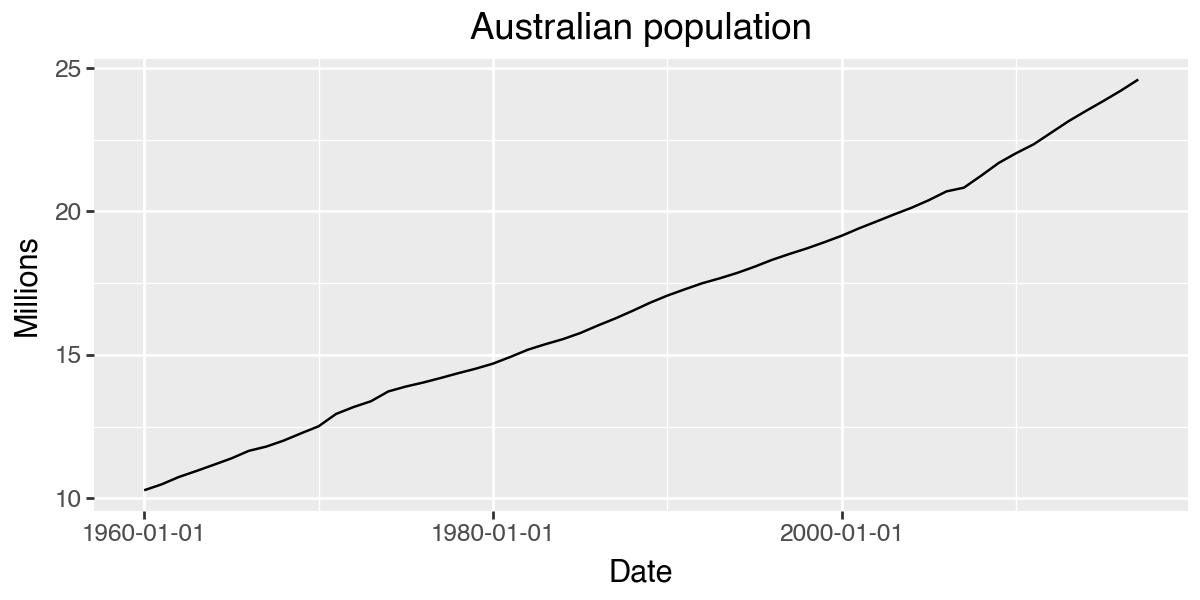

In [3]:
ggplot(aus_economy) \
    + aes(x='Date', y='Pop') \
    + geom_line() \
    + labs(y='Millions', title='Australian population') \
    + theme(figure_size=(6, 3))

In [14]:
fit = sm.tsa.ExponentialSmoothing(aus_economy['Pop'], trend='add').fit()

In [15]:
fit.summary()

Dep. Variable:,Pop,No. Observations:,58
Model:,ExponentialSmoothing,SSE,0.223
Optimized:,True,AIC,-314.493
Trend:,Additive,BIC,-306.251
Seasonal:,None,AICC,-312.846
Seasonal Periods:,None,Date:,"Wed, 20 Nov 2024"
Box-Cox:,False,Time:,13:41:28
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,0.3248179,beta,True


In [22]:
def summarize_holt(fitted):
    output = pd.DataFrame(dict(
        actual=fitted.data.orig_endog,
        level=fitted.level,
        trend=fitted.trend,
        season=fitted.season,
        forecast=fitted.fittedvalues
    ))
    return output

In [26]:
holt_summary = summarize_holt(fit)

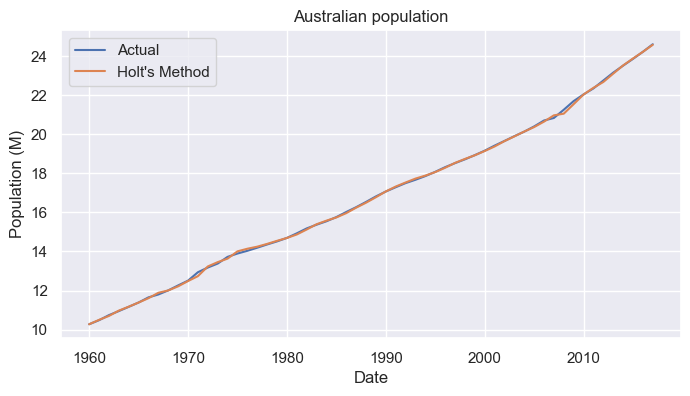

In [36]:
f, ax = plt.subplots(figsize=(8,4))
ax.plot(holt_summary['actual'], label='Actual')
ax.plot(holt_summary['forecast'], label="Holt's Method")
ax.set(ylabel='Population (M)', title='Australian population', xlabel='Date')
ax.legend()
plt.show()

### Damped trend methods
The forecasts generated by Holt's linear method display a constant trend (increasing or decreasing) indefinitely into the future. Empirical evidence indicates that these methods tend to over-forecast, especially for longer forecast horizons. Motivated by this observation, Gardner & McKenzie (1985) introduced a parameter that “dampens” the trend to a flat line some time in the future. 

In conjunction with the smoothing parameters $\alpha$ and $\beta^*$ (with values between 0 and 1 as in Holt's method), this method also includes a damping parameter $0\lt \theta\lt 1$.

$$
\begin{align*}
\hat{y}_{t+h|t} & = \ell_t + (\phi + \phi^2 + \cdots + \phi^h)b_t\\
\ell_t & = \alpha y_t + (1-\alpha)(\ell_{t-1} + \phi b_{t-1}) \\
b_t & = \beta^*(\ell_t-\ell_{t-1}) + (1-\beta^*)\phi b_{t-1}.
\end{align*}
$$
if $\phi=1$, then the method is identical to Holt's linear method. For values between 0 and 1, $\phi$ dampens the trend so that it approaches a constant some time in the future. In fact, the forecasts converge to $\ell_t + \phi b_T(1-\phi)$ as $h\rightarrow\infty$ for any value $0\lt\phi\lt 1$. This means short-run forecasts are trended while long-term run forecasts are constant. 

We usually set the damping parameter $\phi$ to be between 0.8 and 0.98, since the damping effect is significant if $\phi$ is small. In the example below we set it manually to 0.85 to see its effect, but also use the in-built to optimise the value of $\phi$ as is usually done.

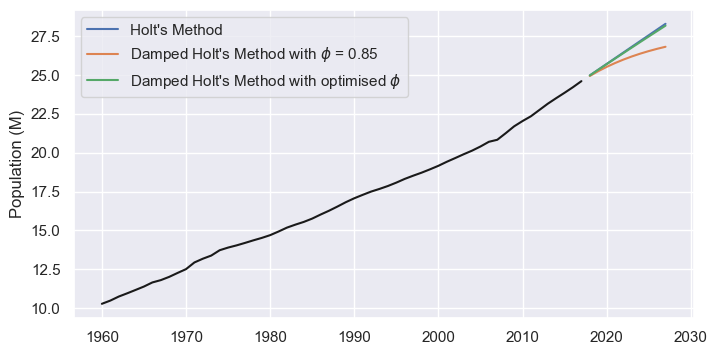

In [54]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(aus_economy['Pop'], 'k')

fit_holt = sm.tsa.ExponentialSmoothing(aus_economy['Pop'], trend='add').fit()
ax.plot(fit_holt.forecast(10), label="Holt's Method")

fit_holt_damped_manual = sm.tsa.ExponentialSmoothing(aus_economy['Pop'], trend='add', damped_trend=True).fit(damping_trend=0.9)
ax.plot(fit_holt_damped_manual.forecast(10), label="Damped Holt's Method with $\phi$ = 0.85")

fit_holt_damped = sm.tsa.ExponentialSmoothing(aus_economy['Pop'], trend='add', damped_trend=True).fit()
ax.plot(fit_holt_damped.forecast(10), label="Damped Holt's Method with optimised $\phi$")

ax.legend()
ax.set(ylabel="Population (M)")
plt.show();


In [52]:
fit_holt_damped.summary()

Dep. Variable:,Pop,No. Observations:,58
Model:,ExponentialSmoothing,SSE,0.226
Optimized:,True,AIC,-311.644
Trend:,Additive,BIC,-301.342
Seasonal:,None,AICC,-309.404
Seasonal Periods:,None,Date:,"Wed, 20 Nov 2024"
Box-Cox:,False,Time:,14:20:18
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,0.3545701,beta,True


We see the optimised damping parameter $\phi$ = 0.995, which is extremely close to 1 (Holt's method).

### Example: Internet usage

In [3]:
import rdatasets

In [4]:
www_usage = rdatasets.data('datasets', 'WWWusage')

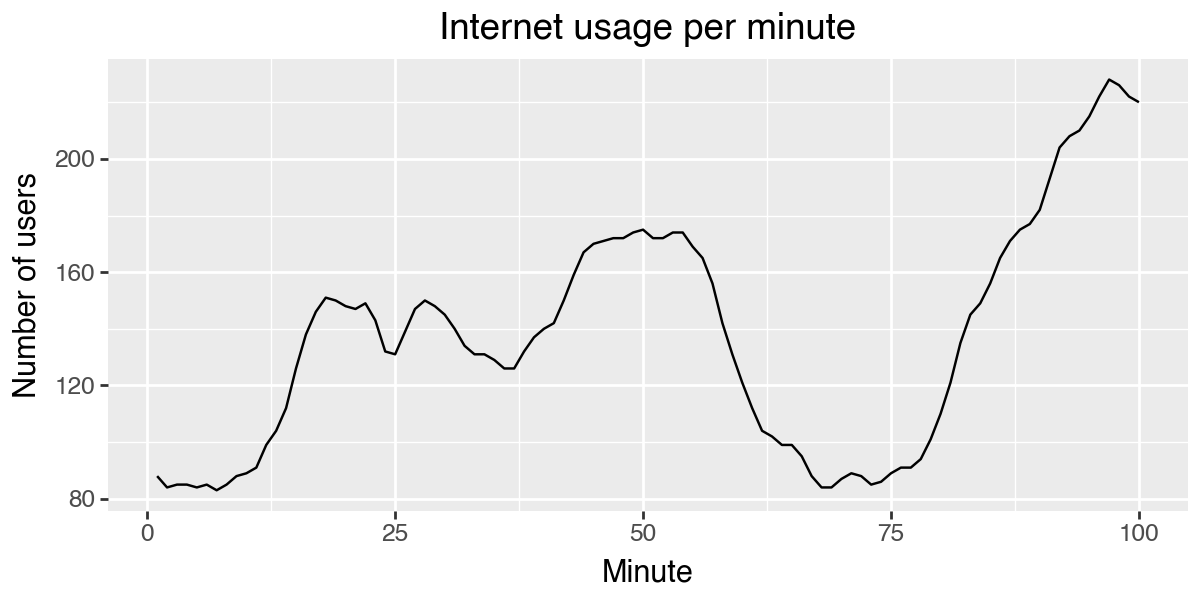

In [5]:
ggplot(www_usage, mapping=aes(x='time', y='value')) \
    + geom_line() \
    + theme(figure_size=(6, 3)) \
    + labs(x='Minute', y='Number of users', title='Internet usage per minute')

We use time series cross-validation to compare the one-step forecast accuracy of the three exponential smoothing methods. We need to use the `statespace` version of `ExponentialSmoothing` to calculate confidence intervals.

In [ ]:
Y = www_usage.value
models = dict(
    SES = sm.tsa.statespace.ExponentialSmoothing(Y).fit(),
    Holt = sm.tsa.statespace.ExponentialSmoothing(Y, trend='add').fit(),
    DampedHolt = sm.tsa.statespace.ExponentialSmoothing(Y, trend='add', damped_trend=True).fit()
)

In [10]:
compute_accuracy(Y, models)

,RMSE,MAE,MAPE
SES,5.771104,4.480575,3.368179
Holt,3.569613,2.920306,2.267657
DampedHolt,3.390966,2.714095,2.108654


We see that both MAE and MSE show that Damped Holt's Method performs better than the others.

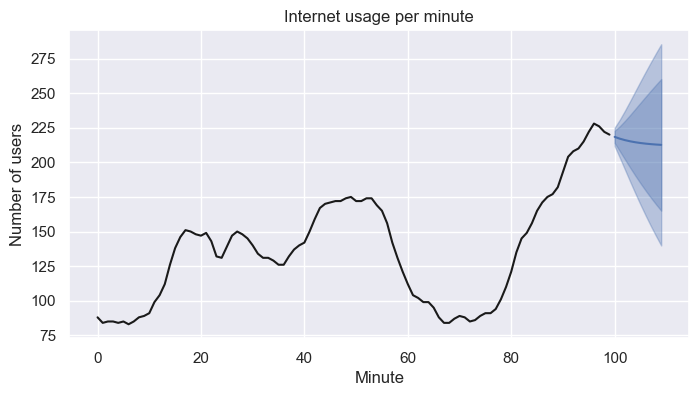

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(Y, 'k')

m = models['DampedHolt']
fc = m.get_forecast(10)
ax.plot(fc.predicted_mean)
    
p_int = fc.conf_int(alpha=.05)
ax.fill_between(p_int.index, p_int['lower value'], p_int['upper value'], alpha=.33, color='C0')
p_int = fc.conf_int(alpha=.2)
ax.fill_between(p_int.index, p_int['lower value'], p_int['upper value'], alpha=.33, color='C0')

ax.set(xlabel='Minute', ylabel='Number of users', title='Internet usage per minute')
plt.show();


#### Differences between Statsmodels’ exponential smoothing model classes
https://www.statsmodels.org/stable/statespace.html

There are several differences between this model class, available at `sm.tsa.statespace.ExponentialSmoothing`, and the model class available at `sm.tsa.ExponentialSmoothing`.

- This model class only supports *linear* exponential smoothing models, while `sm.tsa.ExponentialSmoothing` also supports multiplicative models.

- This model class puts the exponential smoothing models into state space form and then applies the Kalman filter to estimate the states, while `sm.tsa.ExponentialSmoothing` is based on exponential smoothing recursions. In some cases, this can mean that estimating parameters with this model class will be somewhat slower than with `sm.tsa.ExponentialSmoothing`.

- This model class can produce confidence intervals for forecasts, based on an assumption of Gaussian errors, while `sm.tsa.ExponentialSmoothing` does not support confidence intervals.

- This model class supports concentrating initial values out of the objective function, which can improve performance when there are many initial states to estimate (for example when the seasonal periodicity is large).
This model class supports many advanced features available to state space models, such as diagnostics and fixed parameters.